In [1]:
import numpy as np

from matplotlib import pyplot as plt

import gpflow

import sys
sys.path.append('../')

from mfgpflow.data_loader import PowerSpecs
from mfgpflow.linear import MultiFidelityGPModel

def generate_data(folder: str = "data/matter_power_1128_Box1000_Part750_36_Box1000_Part3000_z0"):
    data = PowerSpecs()
    data.read_from_txt(folder=folder)
    return data

data = generate_data("../data/matter_power_1128_Box1000_Part750_36_Box1000_Part3000_z0")

Text(0, 0.5, '$P_{k}$')

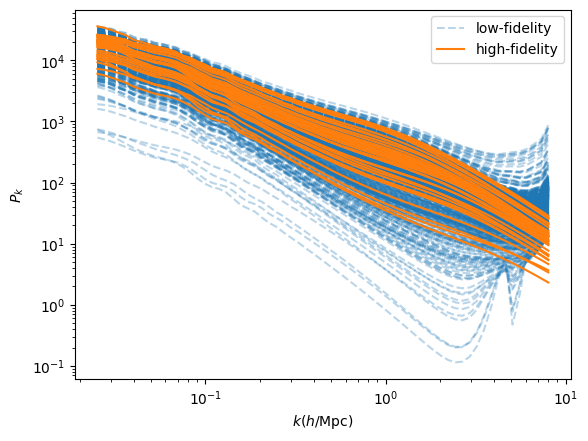

In [2]:
# visualize training spectra
for i,y_train in enumerate(data.Y_train[0]):
    if i == 0:
        plt.loglog(10**data.kf, 10**y_train, label="low-fidelity", color="C0", ls='--', alpha=0.3)
    else:
        plt.loglog(10**data.kf, 10**y_train, color="C0", ls='--', alpha=0.3)
for i,y_train in enumerate(data.Y_train[1]):
    if i == 0:
        plt.loglog(10**data.kf, 10**y_train, label="high-fidelity", color="C1")
    else:
        plt.loglog(10**data.kf, 10**y_train, color="C1")
plt.legend()
plt.xlabel(r"$k (h/\mathrm{Mpc})$")
plt.ylabel(r"$P_{k}$")


## Prepare Goku multi-fidelity data (z=0)

## Multi-bin emulator (All output bins shared the same GP)

In [3]:

# 🔹 1️⃣ Load Data
X_LF, Y_LF = data.X_train_norm[0], data.Y_train_norm[0]  # LF Data (50, 5) → (50, 49)
X_HF, Y_HF = data.X_train_norm[1], data.Y_train_norm[1]  # HF Data (3, 5) → (3, 49)
X_test_HF, Y_test_HF = data.X_test_norm[0], data.Y_test[0]  # Test HF Data (10, 5) → (10, 49)



# 🔹 2️⃣ Prepare Training Data
n_LF, n_HF = X_LF.shape[0], X_HF.shape[0]  # Number of points
num_input = X_LF.shape[1]  # Number of input dimensions
output_dim = Y_LF.shape[1]  # 64 output dimensions

# Append fidelity indicators (0 for LF, 1 for HF)
X_LF_aug = np.hstack([X_LF, np.zeros((n_LF, 1))])  # Append 0 for LF
X_HF_aug = np.hstack([X_HF, np.ones((n_HF, 1))])   # Append 1 for HF

# Combine datasets
X_train = np.vstack([X_LF_aug, X_HF_aug])  # Shape: (1164, 11)
Y_train = np.vstack([Y_LF, Y_HF])  # Shape: (1164, 64)

# 🔹 3️⃣ Define Multi-Fidelity GP Model
kernel_L = gpflow.kernels.RBF(lengthscales=np.ones(num_input), variance=1.0)  # LF Kernel
kernel_delta = gpflow.kernels.RBF(lengthscales=np.ones(num_input), variance=1.0)  # Discrepancy Kernel

mf_gp = MultiFidelityGPModel(X_train, Y_train, kernel_L, kernel_delta)

# 🔹 4️⃣ Train the Model
import time

start_time = time.time()
mf_gp.optimize(max_iters=1000, use_adam=True, learning_rate=0.1, unfix_noise_after=500)
print(f"Training took {time.time() - start_time:.2f} seconds")

Optimizing with Adam...


2025-02-17 22:16:33.513276: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


🔹 Iteration 0: Loss = 95216.01782973186
🔹 Iteration 100: Loss = 139100.27740368416
🔹 Iteration 200: Loss = 140867.28988449488
🔹 Iteration 300: Loss = 141708.46920153778
🔹 Iteration 400: Loss = 142236.01808225922
🔹 Unfixing noise at iteration 500
🔹 Iteration 500: Loss = 142611.01593941066
🔹 Iteration 600: Loss = 142897.19935510925
🔹 Iteration 700: Loss = 143125.77957099146
🔹 Iteration 800: Loss = 143314.23225758955
🔹 Iteration 900: Loss = 143468.40684723994
Training took 142.36 seconds


Text(0, 0.5, 'Loss')

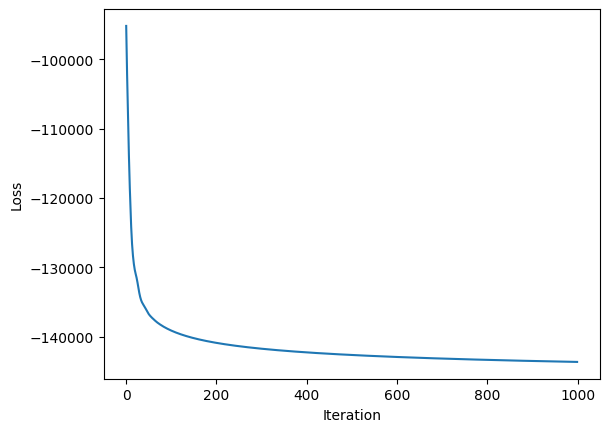

In [4]:
# loss history
plt.plot(mf_gp.loss_history)
plt.xlabel("Iteration")
plt.ylabel("Loss")

Test on different outputs

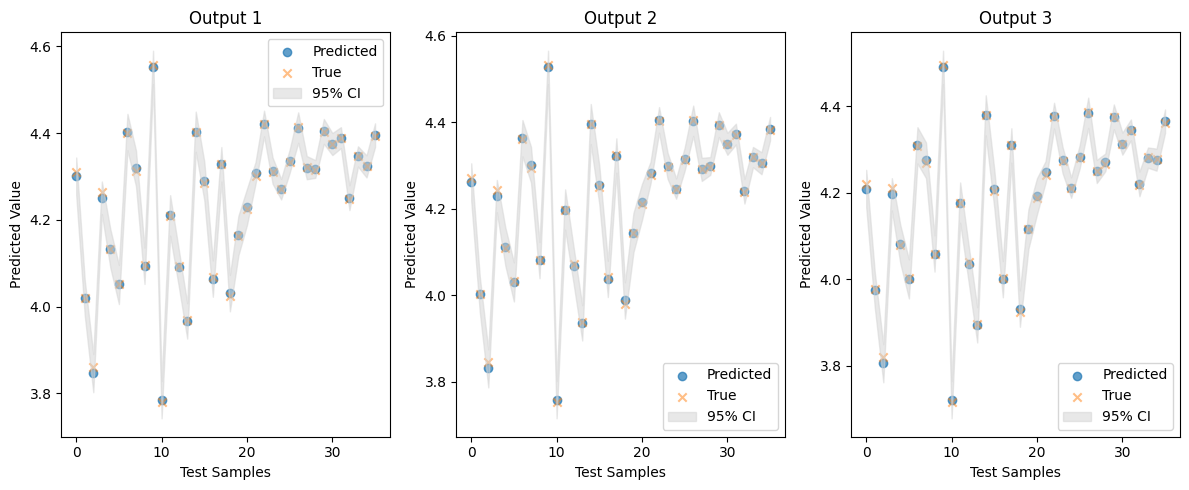

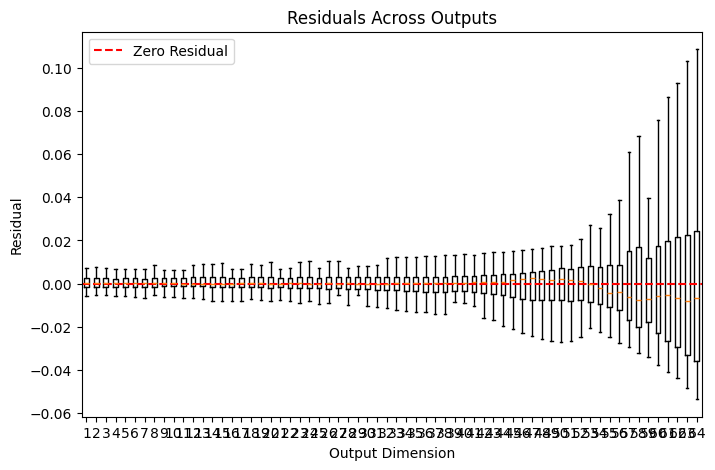

In [5]:

# 🔹 5️⃣ Make Predictions on HF Test Set
num_test_points = X_test_HF.shape[0]
X_test_HF_aug = np.hstack([X_test_HF, np.ones((num_test_points, 1))])  # Add HF indicator (1)
mean_pred, var_pred = mf_gp.predict_f(X_test_HF_aug)  # Predict

# 🔹 6️⃣ Compute Residuals
residuals = mean_pred.numpy() - Y_test_HF  # Shape: (10, 49)

# 🔹 7️⃣ Plot Predictions for 3 Output Dimensions
plt.figure(figsize=(12, 5))

for i in range(3):  # Plot 3 output dimensions
    plt.subplot(1, 3, i+1)
    plt.scatter(np.arange(num_test_points), mean_pred[:, i], label="Predicted", alpha=0.7)
    plt.scatter(np.arange(num_test_points), Y_test_HF[:, i], label="True", alpha=0.5, marker="x")
    plt.fill_between(np.arange(num_test_points), 
                     (mean_pred[:, i] - 1.96 * np.sqrt(var_pred[:, i])).numpy(), 
                     (mean_pred[:, i] + 1.96 * np.sqrt(var_pred[:, i])).numpy(), 
                     color="lightgray", alpha=0.5, label="95% CI")
    plt.title(f"Output {i+1}")
    plt.xlabel("Test Samples")
    plt.ylabel("Predicted Value")
    plt.legend()

plt.tight_layout()
plt.show()

# 🔹 8️⃣ Residual Plot
plt.figure(figsize=(8, 5))
plt.boxplot(residuals, showfliers=False)
plt.axhline(0, linestyle="--", color="red", label="Zero Residual")
plt.title("Residuals Across Outputs")
plt.xlabel("Output Dimension")
plt.ylabel("Residual")
plt.legend()
plt.show()

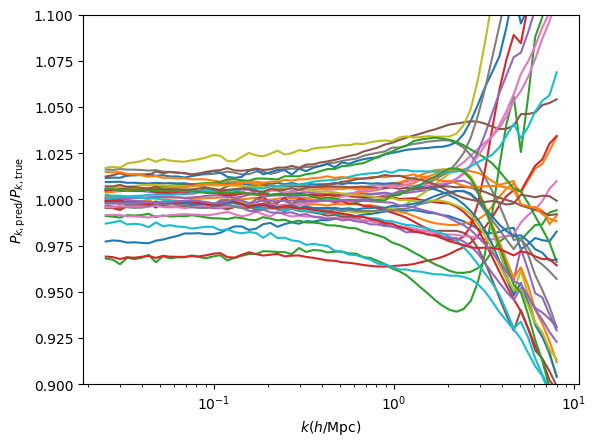

Text(0, 0.5, '$P_{k,\\mathrm{pred}}-P_{k,\\mathrm{true}}$')

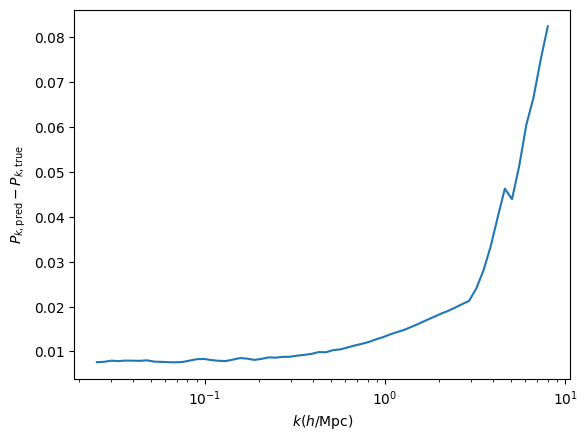

In [6]:
# Predicted vs True Plot across k
plt.semilogx(10**data.kf, (10**mean_pred/10**Y_test_HF).numpy().T);
plt.ylim(0.9, 1.1)
plt.xlabel(r"$k (h/\mathrm{Mpc})$")
plt.ylabel(r"$P_{k,\mathrm{pred}}/P_{k,\mathrm{true}}$")
plt.show()
# absolute error
plt.semilogx(10**data.kf, np.abs((10**mean_pred/10**Y_test_HF-1).numpy()).mean(axis=0));
plt.xlabel(r"$k (h/\mathrm{Mpc})$")
plt.ylabel(r"$P_{k,\mathrm{pred}}-P_{k,\mathrm{true}}$")

## SingleBin Training but with Sparse GP for the speed

Training in Single Bin using `gpflow.kernels.SeparateIndependent`, which is the internal multi-output kernel for singlebin training (so no need to loop over k bins). And for large dataset to optimize the speed of inverting the matrix, we use sparse gp.

In [7]:
from mfgpflow.singlebin_svgp import SingleBinSVGP
import numpy as np
import gpflow
import tensorflow as tf
from sklearn.cluster import KMeans

# 🔹 2️⃣ Prepare Training Data
num_inducing = 300  # Reduce inducing points to prevent overfitting

# 🔹 3️⃣ Define Multi-Fidelity GP Model
# ✅ Define base kernels for LF and HF discrepancy
kernel_L = gpflow.kernels.SquaredExponential(lengthscales=np.ones(num_input), variance=1.0)
kernel_delta = gpflow.kernels.SquaredExponential(lengthscales=np.ones(num_input), variance=1.0)

# ✅ Optimize Inducing Points using K-Means Clustering
kmeans = KMeans(n_clusters=num_inducing, random_state=42).fit(X_train)
Z_init = kmeans.cluster_centers_

# ✅ Initialize the Latent Multi-Fidelity Coregionalization SVGP model
mf_gp = SingleBinSVGP(
    X_train, Y_train,
    kernel_L, kernel_delta,
    num_outputs=output_dim,
    Z=Z_init,
)

# 🔹 4️⃣ Train the Model with Adaptive Learning Rate
start_time = time.time()
mf_gp.optimize(
    (X_train, Y_train),
    max_iters=1000,  # Reduce training iterations
    initial_lr=0.1,  # Lower learning rate for stability
    unfix_noise_after=500,  # Delay unfixing noise variance
    # decay_lr=True  # Enable learning rate decay
)

print(f"Training took {time.time() - start_time:.2f} seconds")

🔹 KMeans Inducing Points: [[6.66666667e-04 8.72666667e-01 3.79333125e-01 ... 3.00666522e-01
  8.95333300e-01 0.00000000e+00]
 [6.05897460e-01 4.53850095e-01 3.98176295e-01 ... 2.29571398e-01
  6.16033430e-01 0.00000000e+00]
 [6.13039211e-01 5.66749509e-01 5.96145066e-01 ... 1.17815286e-01
  4.57780520e-01 0.00000000e+00]
 ...
 [1.63333333e-01 2.19333333e-01 1.80000000e-02 ... 4.30000000e-01
  3.76666700e-01 0.00000000e+00]
 [7.58000000e-01 2.20666667e-01 3.80000000e-02 ... 2.14000000e-01
  4.11333330e-01 0.00000000e+00]
 [9.34000000e-01 9.67333333e-01 6.24666875e-01 ... 4.38000000e-01
  9.30000000e-01 0.00000000e+00]]
🔹 Optimizing...
Instructions for updating:
Use fn_output_signature instead
🔹 Iteration 0: ELBO = 123854.11816556432
🔹 Iteration 10: ELBO = 47572.634334344475
🔹 Iteration 20: ELBO = 12762.12739651364
🔹 Iteration 30: ELBO = -20667.779991318
🔹 Iteration 40: ELBO = -47158.76306156418
🔹 Iteration 50: ELBO = -57731.056502046355
🔹 Iteration 60: ELBO = -73019.50981587108
🔹 Iterat

🔍 Final Residuals: -0.0001 ± 0.0122
✅ Model trained and predictions completed!
🔍 Learned noise variance: 0.0005715291531660407
🔍 HF Prediction MSE: 0.0001


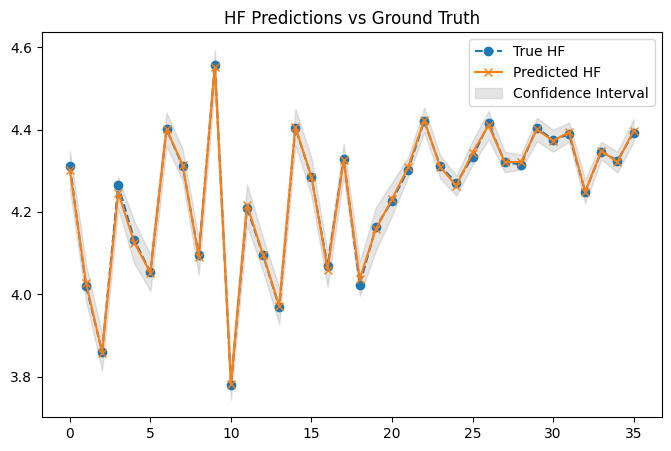

In [8]:

# 🔹 5️⃣ Make Predictions on HF Test Set
X_test_HF_aug = np.hstack([X_test_HF, np.ones((num_test_points, 1))])  # Add HF indicator (1)
mean_pred, var_pred = mf_gp.predict_f(X_test_HF_aug)

# 🔹 6️⃣ Compute Residuals
residuals = mean_pred.numpy() - Y_test_HF  # Shape: (10, 49)

# ✅ Print summary
print(f"🔍 Final Residuals: {residuals.mean():.4f} ± {residuals.std():.4f}")
print(f"✅ Model trained and predictions completed!")

# ✅ Check Noise Variance
print(f"🔍 Learned noise variance: {mf_gp.likelihood.variance.numpy()}")

# ✅ Evaluate Test Performance
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(Y_test_HF, mean_pred.numpy())
print(f"🔍 HF Prediction MSE: {mse:.4f}")

# ✅ Visualize Predictions
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))
plt.plot(Y_test_HF[:, 0], label="True HF", linestyle="--", marker="o")
plt.plot(mean_pred.numpy()[:, 0], label="Predicted HF", linestyle="-", marker="x")
plt.fill_between(
    np.arange(len(Y_test_HF[:, 0])),
    mean_pred.numpy()[:, 0] - 2 * np.sqrt(var_pred.numpy()[:, 0]),
    mean_pred.numpy()[:, 0] + 2 * np.sqrt(var_pred.numpy()[:, 0]),
    alpha=0.2, color="gray", label="Confidence Interval"
)
plt.legend()
plt.title("HF Predictions vs Ground Truth")
plt.show()

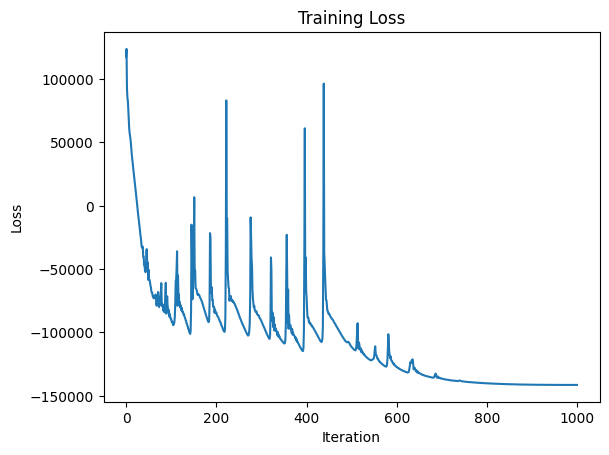

In [9]:
plt.plot(mf_gp.loss_history)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()

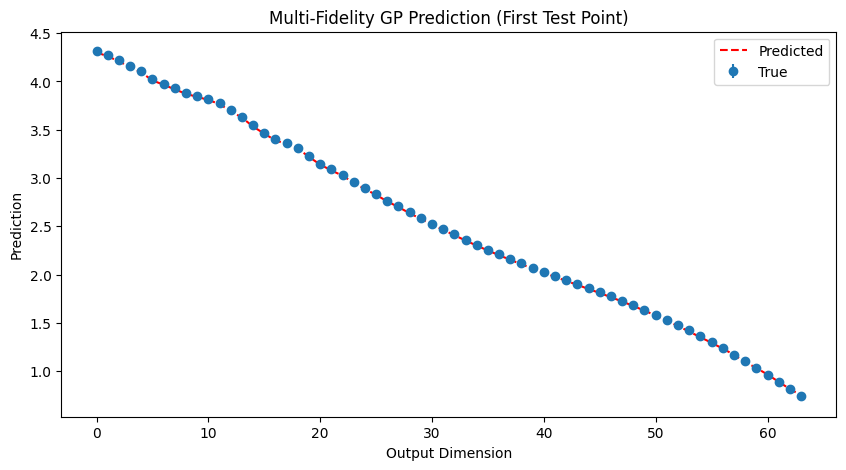

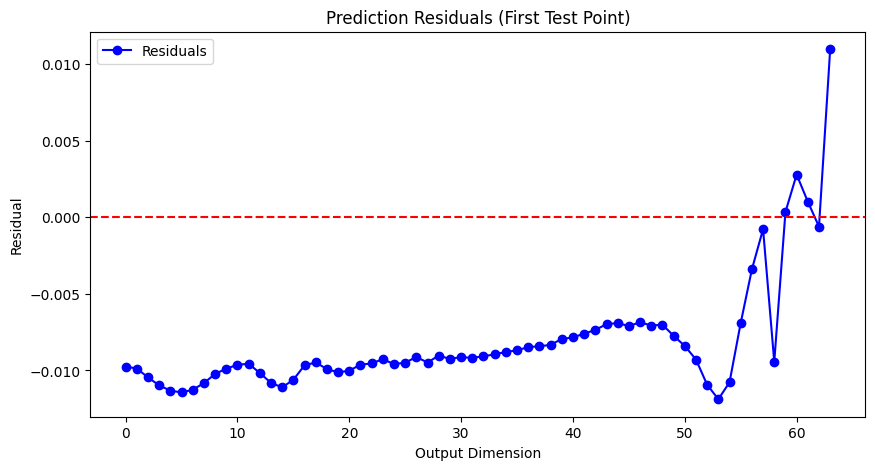

In [10]:

# 🔹 7️⃣ Plot Predictions vs Ground Truth
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.errorbar(np.arange(output_dim), Y_test_HF[0], yerr=np.sqrt(var_pred.numpy()[0]), fmt='o', label="True")
plt.plot(np.arange(output_dim), mean_pred.numpy()[0], 'r--', label="Predicted")
plt.xlabel("Output Dimension")
plt.ylabel("Prediction")
plt.legend()
plt.title("Multi-Fidelity GP Prediction (First Test Point)")
plt.show()

# 🔹 8️⃣ Residual Plot
plt.figure(figsize=(10, 5))
plt.plot(np.arange(output_dim), residuals[0], 'bo-', label="Residuals")
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Output Dimension")
plt.ylabel("Residual")
plt.legend()
plt.title("Prediction Residuals (First Test Point)")
plt.show()

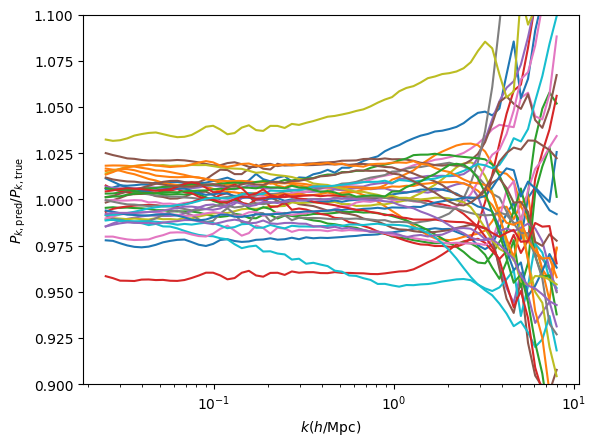

Text(0, 0.5, '$P_{k,\\mathrm{pred}}-P_{k,\\mathrm{true}}$')

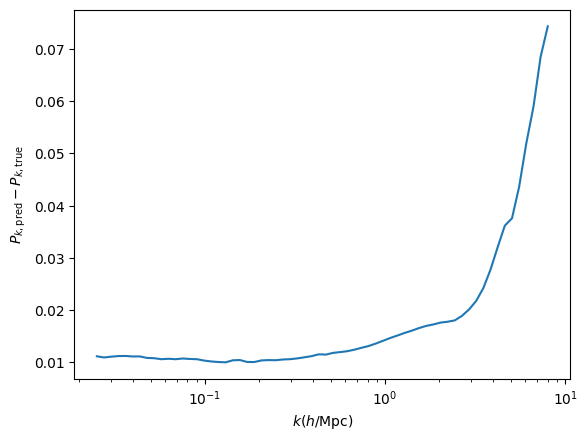

In [11]:
plt.semilogx(10**data.kf, (10**mean_pred/10**Y_test_HF).numpy().T);
plt.ylim(0.9, 1.1)
plt.xlabel(r"$k (h/\mathrm{Mpc})$")
plt.ylabel(r"$P_{k,\mathrm{pred}}/P_{k,\mathrm{true}}$")
plt.show()
# absolute error
plt.semilogx(10**data.kf, np.abs((10**mean_pred/10**Y_test_HF - 1).numpy()).mean(axis=0));
plt.xlabel(r"$k (h/\mathrm{Mpc})$")
plt.ylabel(r"$P_{k,\mathrm{pred}}-P_{k,\mathrm{true}}$")

In [12]:
mf_gp

name,class,transform,prior,trainable,shape,dtype,value
SingleBinSVGP.kernel.kernels[0].kernel_L.variance,Parameter,Softplus,,True,(),float64,0.24122
SingleBinSVGP.kernel.kernels[0].kernel_L.lengthscales,Parameter,Softplus,,True,"(10,)",float64,"[3.28571, 6.8688, 4.99022..."
SingleBinSVGP.kernel.kernels[0].kernel_delta.variance,Parameter,Softplus,,True,(),float64,1.04113
SingleBinSVGP.kernel.kernels[0].kernel_delta.lengthscales,Parameter,Softplus,,True,"(10,)",float64,"[9.20239, 9.92748, 5.47572..."
SingleBinSVGP.kernel.kernels[0].rho,Parameter,Softplus,,True,"(1, 1)",float64,[[0.91205]]
SingleBinSVGP.kernel.kernels[1].kernel_L.variance,Parameter,Softplus,,True,(),float64,0.2483
SingleBinSVGP.kernel.kernels[1].kernel_L.lengthscales,Parameter,Softplus,,True,"(10,)",float64,"[2.96007, 6.86991, 4.88927..."
SingleBinSVGP.kernel.kernels[1].kernel_delta.variance,Parameter,Softplus,,True,(),float64,1.03503
SingleBinSVGP.kernel.kernels[1].kernel_delta.lengthscales,Parameter,Softplus,,True,"(10,)",float64,"[9.1502, 9.93178, 5.51193..."
SingleBinSVGP.kernel.kernels[1].rho,Parameter,Softplus,,True,"(1, 1)",float64,[[0.91075]]


Visualize the rho

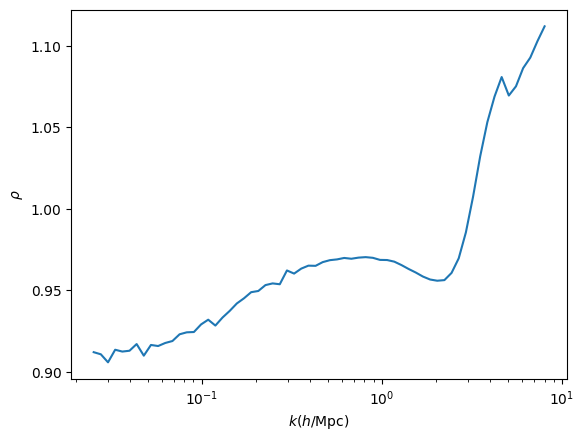

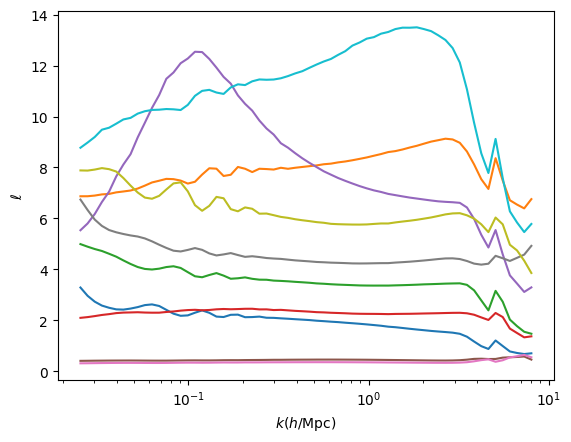

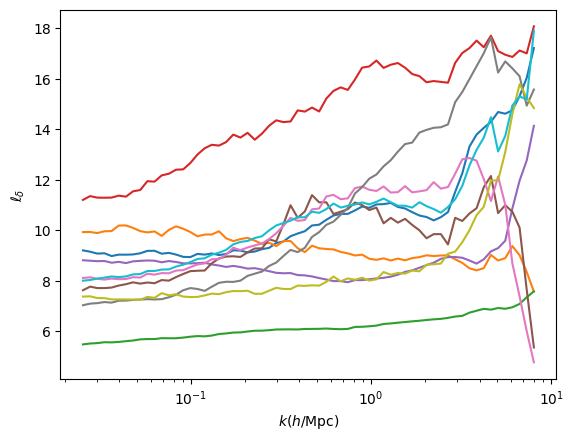

In [13]:
num_outputs = len(mf_gp.kernel.kernels)

rho_values = []
lengthscale_values = []
lengthscale_delta_values = []

for i in range(num_outputs):
    rho_values.append(mf_gp.kernel.kernels[i].rho.numpy()[0])
    lengthscale_values.append(mf_gp.kernel.kernels[i].kernel_L.lengthscales.numpy())
    lengthscale_delta_values.append(mf_gp.kernel.kernels[i].kernel_delta.lengthscales.numpy())


plt.plot(10**data.kf, rho_values)
plt.xlabel(r"$k (h/\mathrm{Mpc})$")
plt.ylabel(r"$\rho$")
plt.xscale("log")
plt.show()

plt.plot(10**data.kf, lengthscale_values)
plt.xlabel(r"$k (h/\mathrm{Mpc})$")
plt.ylabel(r"$\ell$")
plt.xscale("log")
plt.show()


plt.plot(10**data.kf, lengthscale_delta_values)
plt.xlabel(r"$k (h/\mathrm{Mpc})$")
plt.ylabel(r"$\ell_{\delta}$")
plt.xscale("log")


## Latent space inference : Factor analysis using the mixing matrix

This effective reduce number of GP per bin to number of GP per latent space dimension.

In [14]:
from mfgpflow.linear_svgp import LatentMFCoregionalizationSVGP

In [15]:
import numpy as np
import gpflow
import tensorflow as tf
from sklearn.cluster import KMeans

num_latents = 15  # Reduce latent GPs to match HF sparsity
num_inducing = 300  # Reduce inducing points to prevent overfitting

# ✅ Append fidelity indicators (0 for LF, 1 for HF)
X_LF_aug = np.hstack([X_LF, np.zeros((n_LF, 1))])  # LF data with fidelity=0
X_HF_aug = np.hstack([X_HF, np.ones((n_HF, 1))])   # HF data with fidelity=1

# ✅ Combine datasets
X_train = np.vstack([X_LF_aug, X_HF_aug])  # Shape: (53, 6)
Y_train = np.vstack([Y_LF, Y_HF])  # Shape: (53, 49)

# 🔹 3️⃣ Define Multi-Fidelity GP Model
# ✅ Define base kernels for LF and HF discrepancy
kernel_L = gpflow.kernels.SquaredExponential(lengthscales=np.ones(num_input), variance=1.0)
kernel_delta = gpflow.kernels.SquaredExponential(lengthscales=np.ones(num_input), variance=1.0)

# ✅ Optimize Inducing Points using K-Means Clustering
kmeans = KMeans(n_clusters=num_inducing, random_state=42).fit(X_train)
Z_init = kmeans.cluster_centers_

# ✅ Initialize the Latent Multi-Fidelity Coregionalization SVGP model
mf_gp = LatentMFCoregionalizationSVGP(
    X_train, Y_train,
    kernel_L, kernel_delta,
    num_outputs=output_dim, num_latents=num_latents, Z=Z_init
)

# 🔹 4️⃣ Train the Model with Adaptive Learning Rate
start_time = time.time()
mf_gp.optimize(
    (X_train, Y_train),
    max_iters=2000,  # Reduce training iterations
    initial_lr=0.1,  # Lower learning rate for stability
    unfix_noise_after=1000,  # Delay unfixing noise variance
    # decay_lr=True  # Enable learning rate decay
)

print(f"Training took {time.time() - start_time:.2f} seconds")

🔹 KMeans Inducing Points: [[6.66666667e-04 8.72666667e-01 3.79333125e-01 ... 3.00666522e-01
  8.95333300e-01 0.00000000e+00]
 [6.05897460e-01 4.53850095e-01 3.98176295e-01 ... 2.29571398e-01
  6.16033430e-01 0.00000000e+00]
 [6.13039211e-01 5.66749509e-01 5.96145066e-01 ... 1.17815286e-01
  4.57780520e-01 0.00000000e+00]
 ...
 [1.63333333e-01 2.19333333e-01 1.80000000e-02 ... 4.30000000e-01
  3.76666700e-01 0.00000000e+00]
 [7.58000000e-01 2.20666667e-01 3.80000000e-02 ... 2.14000000e-01
  4.11333330e-01 0.00000000e+00]
 [9.34000000e-01 9.67333333e-01 6.24666875e-01 ... 4.38000000e-01
  9.30000000e-01 0.00000000e+00]]
🔹 Optimizing...
🔹 Iteration 0: ELBO = 88793.50196683251
🔹 Iteration 10: ELBO = 42505.44992349845
🔹 Iteration 20: ELBO = 8643.839190434635
🔹 Iteration 30: ELBO = -22032.268149080912
🔹 Iteration 40: ELBO = -48295.926029256836
🔹 Iteration 50: ELBO = -67713.05401989256
🔹 Iteration 60: ELBO = -37648.96844618709
🔹 Iteration 70: ELBO = -91519.89745024241
🔹 Iteration 80: ELBO = -

🔍 Final Residuals: -0.0000 ± 0.0061
✅ Model trained and predictions completed!
🔍 Final Learned W Matrix:
[[ 7.34209307e-01  8.49842729e-01  6.82674370e-01  7.70309193e-01
   3.71385272e-01 -4.52062100e-02 -4.03844956e-02 -3.05991925e-01
   2.12939630e-01  1.39344426e-01  2.00623914e-01  2.65279183e-01
   1.92110245e-01  9.04892940e-02 -7.50463928e-03]
 [ 7.39155679e-01  8.30631292e-01  6.80446115e-01  7.78381548e-01
   3.50801976e-01 -3.06351448e-02 -3.64980921e-02 -2.73092736e-01
   2.17812687e-01  1.27321392e-01  2.01332164e-01  2.67445191e-01
   1.91840466e-01  1.10211402e-01 -8.50144014e-03]
 [ 7.47151802e-01  8.14653609e-01  6.73659974e-01  7.65453625e-01
   3.38690290e-01 -1.26461482e-02 -3.10285470e-02 -2.27166801e-01
   2.22741069e-01  1.12751711e-01  2.02149752e-01  2.69414950e-01
   1.90117051e-01  1.32943210e-01 -9.28550871e-03]
 [ 7.40876803e-01  8.15916168e-01  6.70713916e-01  7.41603613e-01
   3.23556975e-01  7.03587699e-03 -2.22905324e-02 -1.74317388e-01
   2.25335625e-0

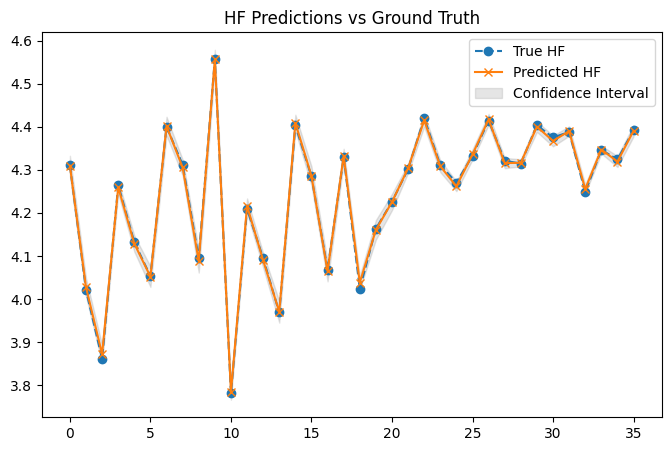

In [16]:
# 🔹 5️⃣ Make Predictions on HF Test Set
X_test_HF_aug = np.hstack([X_test_HF, np.ones((num_test_points, 1))])  # Add HF indicator (1)
mean_pred, var_pred = mf_gp.predict_f(X_test_HF_aug)

# 🔹 6️⃣ Compute Residuals
residuals = mean_pred.numpy() - Y_test_HF  # Shape: (10, 49)

# ✅ Print summary
print(f"🔍 Final Residuals: {residuals.mean():.4f} ± {residuals.std():.4f}")
print(f"✅ Model trained and predictions completed!")

# ✅ Check Learned W Matrix
print("🔍 Final Learned W Matrix:")
print(mf_gp.kernel.W.numpy())

# ✅ Check Noise Variance
print(f"🔍 Learned noise variance: {mf_gp.likelihood.variance.numpy()}")

# ✅ Evaluate Test Performance
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(Y_test_HF, mean_pred.numpy())
print(f"🔍 HF Prediction MSE: {mse:.4f}")

# ✅ Visualize Predictions
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(Y_test_HF[:, 0], label="True HF", linestyle="--", marker="o")
plt.plot(mean_pred.numpy()[:, 0], label="Predicted HF", linestyle="-", marker="x")
plt.fill_between(
    np.arange(len(Y_test_HF[:, 0])),
    mean_pred.numpy()[:, 0] - 2 * np.sqrt(var_pred.numpy()[:, 0]),
    mean_pred.numpy()[:, 0] + 2 * np.sqrt(var_pred.numpy()[:, 0]),
    alpha=0.2, color="gray", label="Confidence Interval"
)
plt.legend()
plt.title("HF Predictions vs Ground Truth")
plt.show()

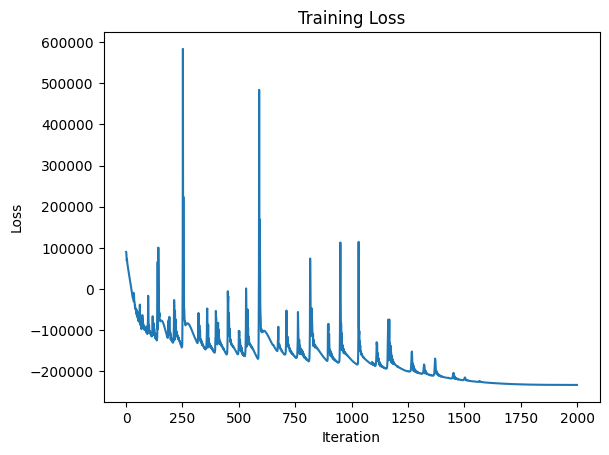

In [17]:
plt.plot(mf_gp.loss_history)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()

Text(0.5, 0, 'Latent Dimension')

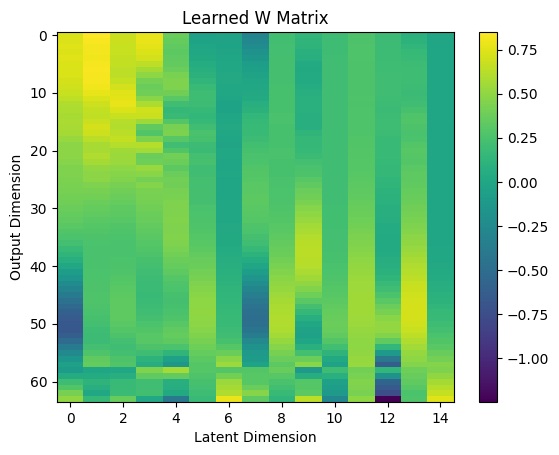

In [18]:
# plot the W matrix
plt.imshow(mf_gp.kernel.W.numpy(), aspect="auto")
plt.colorbar()
plt.title("Learned W Matrix")
plt.ylabel("Output Dimension")
plt.xlabel("Latent Dimension")

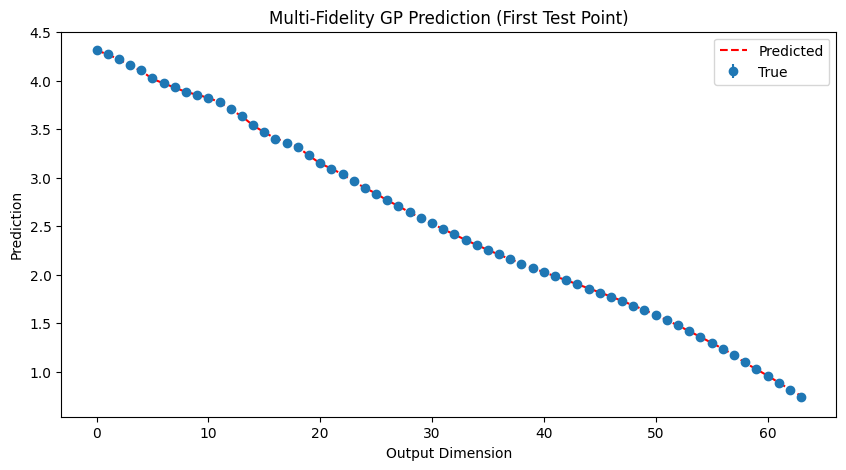

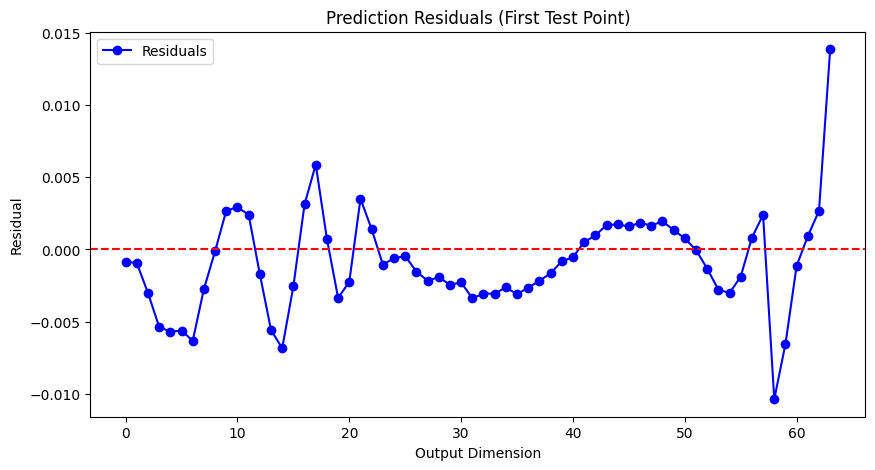

In [19]:

# 🔹 7️⃣ Plot Predictions vs Ground Truth
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.errorbar(np.arange(output_dim), Y_test_HF[0], yerr=np.sqrt(var_pred.numpy()[0]), fmt='o', label="True")
plt.plot(np.arange(output_dim), mean_pred.numpy()[0], 'r--', label="Predicted")
plt.xlabel("Output Dimension")
plt.ylabel("Prediction")
plt.legend()
plt.title("Multi-Fidelity GP Prediction (First Test Point)")
plt.show()

# 🔹 8️⃣ Residual Plot
plt.figure(figsize=(10, 5))
plt.plot(np.arange(output_dim), residuals[0], 'bo-', label="Residuals")
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Output Dimension")
plt.ylabel("Residual")
plt.legend()
plt.title("Prediction Residuals (First Test Point)")
plt.show()

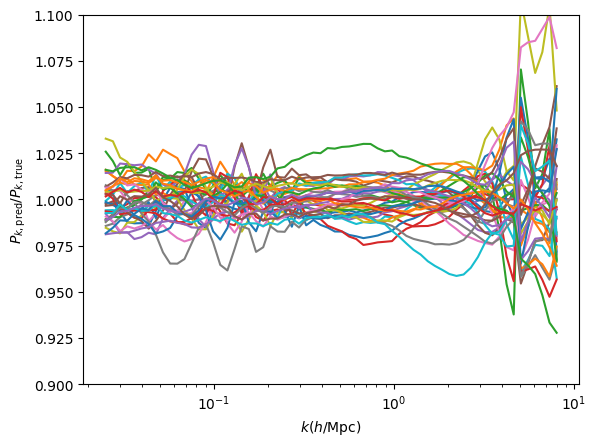

Text(0, 0.5, '$P_{k,\\mathrm{pred}}-P_{k,\\mathrm{true}}$')

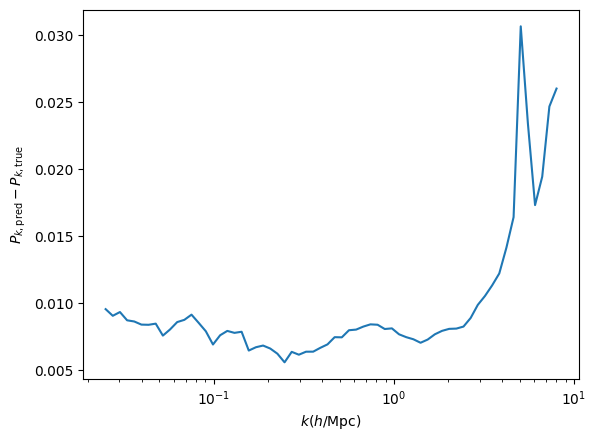

In [20]:
plt.semilogx(10**data.kf, (10**mean_pred/10**Y_test_HF).numpy().T);
plt.ylim(0.9, 1.1)
plt.xlabel(r"$k (h/\mathrm{Mpc})$")
plt.ylabel(r"$P_{k,\mathrm{pred}}/P_{k,\mathrm{true}}$")
plt.show()
# absolute error
plt.semilogx(10**data.kf, np.abs((10**mean_pred/10**Y_test_HF - 1).numpy()).mean(axis=0));
plt.xlabel(r"$k (h/\mathrm{Mpc})$")
plt.ylabel(r"$P_{k,\mathrm{pred}}-P_{k,\mathrm{true}}$")

In [21]:
for var in mf_gp.trainable_variables:
    print(var.name, var.shape)

Variable:0 (300, 15)
fill_triangular:0 (15, 45150)
Variable:0 (300, 11)
identity:0 (64, 15)
softplus:0 (1, 1)
softplus:0 (10,)
softplus:0 ()
softplus:0 (10,)
softplus:0 ()
softplus:0 (1, 1)
softplus:0 (10,)
softplus:0 ()
softplus:0 (10,)
softplus:0 ()
softplus:0 (1, 1)
softplus:0 (10,)
softplus:0 ()
softplus:0 (10,)
softplus:0 ()
softplus:0 (1, 1)
softplus:0 (10,)
softplus:0 ()
softplus:0 (10,)
softplus:0 ()
softplus:0 (1, 1)
softplus:0 (10,)
softplus:0 ()
softplus:0 (10,)
softplus:0 ()
softplus:0 (1, 1)
softplus:0 (10,)
softplus:0 ()
softplus:0 (10,)
softplus:0 ()
softplus:0 (1, 1)
softplus:0 (10,)
softplus:0 ()
softplus:0 (10,)
softplus:0 ()
softplus:0 (1, 1)
softplus:0 (10,)
softplus:0 ()
softplus:0 (10,)
softplus:0 ()
softplus:0 (1, 1)
softplus:0 (10,)
softplus:0 ()
softplus:0 (10,)
softplus:0 ()
softplus:0 (1, 1)
softplus:0 (10,)
softplus:0 ()
softplus:0 (10,)
softplus:0 ()
softplus:0 (1, 1)
softplus:0 (10,)
softplus:0 ()
softplus:0 (10,)
softplus:0 ()
softplus:0 (1, 1)
softplus:0

In [22]:
mf_gp

name,class,transform,prior,trainable,shape,dtype,value
LatentMFCoregionalizationSVGP.kernel.kernels[0].kernel_L.variance,Parameter,Softplus,,True,(),float64,0.01733
LatentMFCoregionalizationSVGP.kernel.kernels[0].kernel_L.lengthscales,Parameter,Softplus,,True,"(10,)",float64,"[1.77801, 9.0288, 3.91462..."
LatentMFCoregionalizationSVGP.kernel.kernels[0].kernel_delta.variance,Parameter,Softplus,,True,(),float64,0.47257
LatentMFCoregionalizationSVGP.kernel.kernels[0].kernel_delta.lengthscales,Parameter,Softplus,,True,"(10,)",float64,"[8.60768, 17.84502, 11.48562..."
LatentMFCoregionalizationSVGP.kernel.kernels[0].rho,Parameter,Softplus,,True,"(1, 1)",float64,[[0.6133]]
LatentMFCoregionalizationSVGP.kernel.kernels[1].kernel_L.variance,Parameter,Softplus,,True,(),float64,0.00027
LatentMFCoregionalizationSVGP.kernel.kernels[1].kernel_L.lengthscales,Parameter,Softplus,,True,"(10,)",float64,"[4.51261, 6.75681, 5.72189..."
LatentMFCoregionalizationSVGP.kernel.kernels[1].kernel_delta.variance,Parameter,Softplus,,True,(),float64,0.6396
LatentMFCoregionalizationSVGP.kernel.kernels[1].kernel_delta.lengthscales,Parameter,Softplus,,True,"(10,)",float64,"[8.15832, 16.71433, 10.80015..."
LatentMFCoregionalizationSVGP.kernel.kernels[1].rho,Parameter,Softplus,,True,"(1, 1)",float64,[[0.70327]]


## Test the save/load function


In [23]:
# You can save the model for later use
# There are other ways, e.g., checkpoint manager, but this is the simplest
mf_gp.save_model("latent_mf_gp.pkl")

✅ Model saved to latent_mf_gp.pkl


In [24]:
import pickle

kernel_L = gpflow.kernels.SquaredExponential(lengthscales=np.ones(num_input), variance=1.0)
kernel_delta = gpflow.kernels.SquaredExponential(lengthscales=np.ones(num_input), variance=1.0)

# ✅ Initialize the Latent Multi-Fidelity Coregionalization SVGP model
mf_gp_new = LatentMFCoregionalizationSVGP(
    X_train, Y_train,
    kernel_L, kernel_delta,
    num_outputs=output_dim, num_latents=num_latents, Z=Z_init
)
with open("latent_mf_gp.pkl", "rb") as f:
    params = pickle.load(f)

# Now you can assign the saved parameters to the new model
gpflow.utilities.multiple_assign(mf_gp_new, params)


🔹 KMeans Inducing Points: [[6.66666667e-04 8.72666667e-01 3.79333125e-01 ... 3.00666522e-01
  8.95333300e-01 0.00000000e+00]
 [6.05897460e-01 4.53850095e-01 3.98176295e-01 ... 2.29571398e-01
  6.16033430e-01 0.00000000e+00]
 [6.13039211e-01 5.66749509e-01 5.96145066e-01 ... 1.17815286e-01
  4.57780520e-01 0.00000000e+00]
 ...
 [1.63333333e-01 2.19333333e-01 1.80000000e-02 ... 4.30000000e-01
  3.76666700e-01 0.00000000e+00]
 [7.58000000e-01 2.20666667e-01 3.80000000e-02 ... 2.14000000e-01
  4.11333330e-01 0.00000000e+00]
 [9.34000000e-01 9.67333333e-01 6.24666875e-01 ... 4.38000000e-01
  9.30000000e-01 0.00000000e+00]]


In [25]:
mf_gp_new

name,class,transform,prior,trainable,shape,dtype,value
LatentMFCoregionalizationSVGP.kernel.kernels[0].kernel_L.variance,Parameter,Softplus,,True,(),float64,0.01733
LatentMFCoregionalizationSVGP.kernel.kernels[0].kernel_L.lengthscales,Parameter,Softplus,,True,"(10,)",float64,"[1.77801, 9.0288, 3.91462..."
LatentMFCoregionalizationSVGP.kernel.kernels[0].kernel_delta.variance,Parameter,Softplus,,True,(),float64,0.47257
LatentMFCoregionalizationSVGP.kernel.kernels[0].kernel_delta.lengthscales,Parameter,Softplus,,True,"(10,)",float64,"[8.60768, 17.84502, 11.48562..."
LatentMFCoregionalizationSVGP.kernel.kernels[0].rho,Parameter,Softplus,,True,"(1, 1)",float64,[[0.6133]]
LatentMFCoregionalizationSVGP.kernel.kernels[1].kernel_L.variance,Parameter,Softplus,,True,(),float64,0.00027
LatentMFCoregionalizationSVGP.kernel.kernels[1].kernel_L.lengthscales,Parameter,Softplus,,True,"(10,)",float64,"[4.51261, 6.75681, 5.72189..."
LatentMFCoregionalizationSVGP.kernel.kernels[1].kernel_delta.variance,Parameter,Softplus,,True,(),float64,0.6396
LatentMFCoregionalizationSVGP.kernel.kernels[1].kernel_delta.lengthscales,Parameter,Softplus,,True,"(10,)",float64,"[8.15832, 16.71433, 10.80015..."
LatentMFCoregionalizationSVGP.kernel.kernels[1].rho,Parameter,Softplus,,True,"(1, 1)",float64,[[0.70327]]


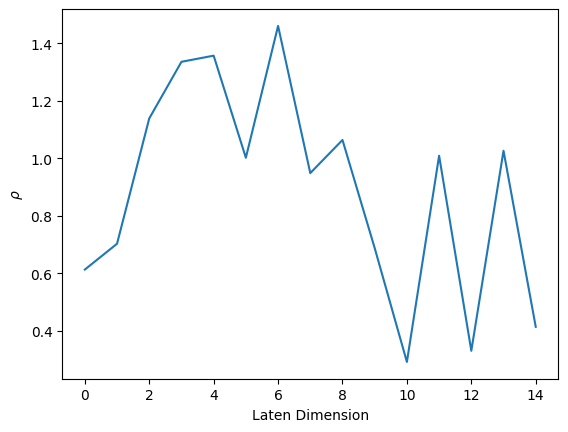

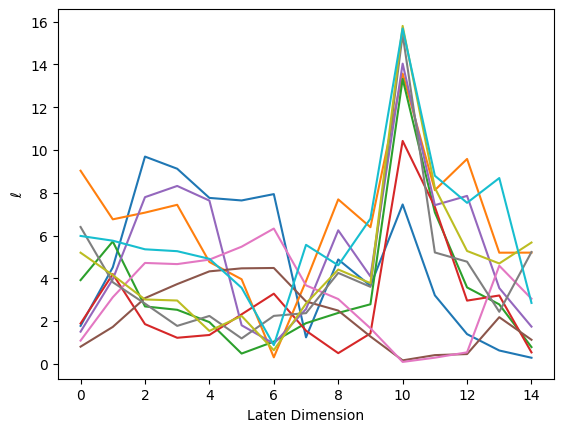

Text(0, 0.5, '$\\ell_{\\delta}$')

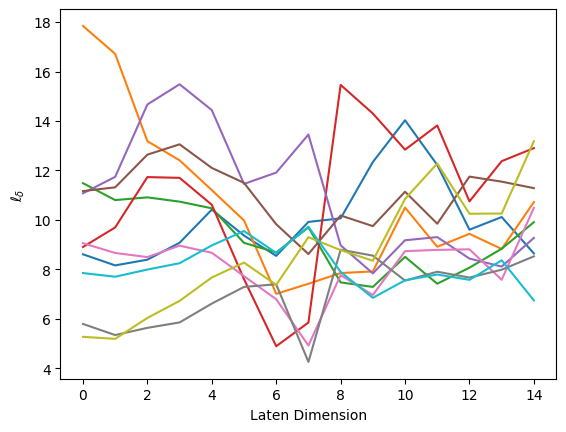

In [26]:
num_outputs = len(mf_gp_new.kernel.kernels)

rho_values = []
lengthscale_values = []
lengthscale_delta_values = []

for i in range(num_outputs):
    rho_values.append(mf_gp_new.kernel.kernels[i].rho.numpy()[0])
    lengthscale_values.append(mf_gp_new.kernel.kernels[i].kernel_L.lengthscales.numpy())
    lengthscale_delta_values.append(mf_gp_new.kernel.kernels[i].kernel_delta.lengthscales.numpy())


plt.plot(range(num_latents), rho_values)
plt.xlabel(r"Laten Dimension")
plt.ylabel(r"$\rho$")
plt.show()

plt.plot(range(num_latents), lengthscale_values)
plt.xlabel(r"Laten Dimension")
plt.ylabel(r"$\ell$")
plt.show()


plt.plot(range(num_latents), lengthscale_delta_values)
plt.xlabel(r"Laten Dimension")
plt.ylabel(r"$\ell_{\delta}$")


Text(0.5, 0, 'Latent Dimension')

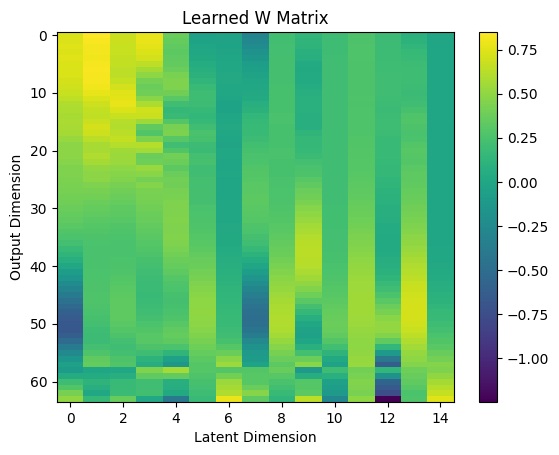

In [27]:
# plot the W matrix
plt.imshow(mf_gp_new.kernel.W.numpy(), aspect="auto")
plt.colorbar()
plt.title("Learned W Matrix")
plt.ylabel("Output Dimension")
plt.xlabel("Latent Dimension")